## Research Question 2: What is the causal relationship between enforced seat belt regulations and fatilities per miles driven?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Avoid false positive chain warnings
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(rc = {'figure.figsize':(15,8)})

### NHTSA DATA

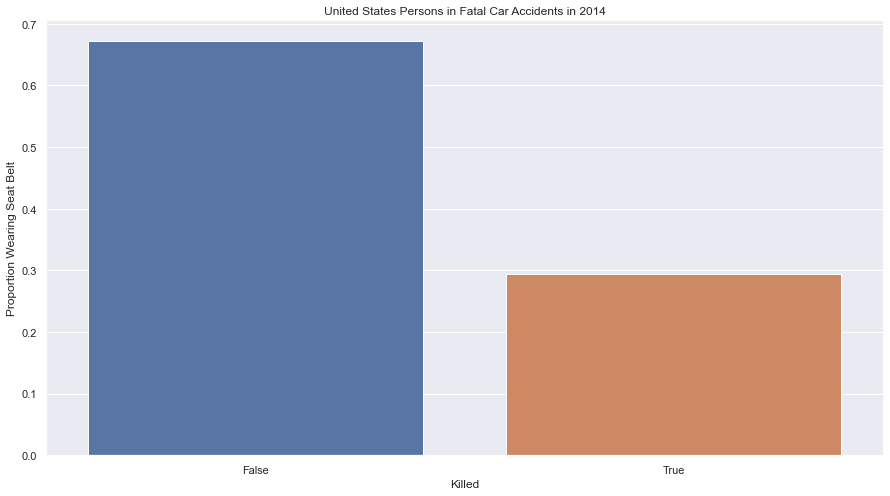

In [2]:
# Read in 2014 the NHTSA dataset for persons involved in accidents
# in which there was at least 1 fatality.
persons_2014 = pd.read_csv("FARS2014NationalCSV/PERSON.CSV", encoding = 'latin-1')
# Plot proportion of people who wore seat belts and died in fatal car accidents 
persons_2014["Killed"] = persons_2014["INJ_SEV"] == 4
persons_2014["Belt"] = persons_2014["REST_USE"] == 3
grouped_persons_2014 = persons_2014.groupby("Killed").agg("mean").reset_index()
p = sns.barplot(x="Killed", y = "Belt", data = grouped_persons_2014)
p.set(xlabel = "Killed", ylabel="Proportion Wearing Seat Belt", title="United States Persons in Fatal Car Accidents in 2014");

### BTS DATA

In [3]:
# Read in state transportation data.
state_transport_data = pd.read_csv("state_transport_data.csv", encoding = "utf-16", sep='\t')

# dictionary with year that each state adopted the primary seatbelt enforcement law.
# float('inf') if not currently adopted.
# Note that seatbelt laws were sometimes adopted within a specific year
# e.g. June 2013 (MENTION)
# https://www.cdc.gov/motorvehiclesafety/calculator/factsheet/seatbelt.html "Primary Enforcement" column
year_adopted = {'Alabama': 1999, 'Alaska': 2006, 'Arizona': float('inf'), 'Arkansas': 2009, 'California': 1993,
       'Colorado': float('inf'), 'Connecticut': 1986, 'Delaware': 1997, 'District of Columbia': 2003,
       'Florida': 2009, 'Georgia': 1996, 'Hawaii': 1985, 'Idaho': float('inf'), 'Illinois': 2003, 'Indiana': 1998,
       'Iowa': 1986, 'Kansas': 2010, 'Kentucky': 2006, 'Louisiana': 1995, 'Maine': 2007, 'Maryland': 1997,
       'Massachusetts': float('inf'), 'Michigan': 2000, 'Minnesota': 2009, 'Mississippi': 2006,
       'Missouri': float('inf'), 'Montana': float('inf'), 'Nebraska': float('inf'), 'Nevada':float('inf'), 'New Hampshire':float('inf'),
       'New Jersey':2000, 'New Mexico':1986, 'New York':1984, 'North Carolina':2006,
       'North Dakota':float('inf'), 'Ohio':float('inf'), 'Oklahoma':1997, 'Oregon':1990, 'Pennsylvania':float('inf'),
       'Rhode Island':2011, 'South Carolina':2005, 'South Dakota':float('inf'), 'Tennessee':2004,
       'Texas': 1985, 'Utah':float('inf'), 'Vermont':float('inf'), 'Virginia':float('inf'),
       'Washington':2002, 'West Virginia':2013, 'Wisconsin':2009, 'Wyoming':float('inf')}
# Note that some states have primary enforcement for children under 16 or children under 18.
# These were treated as having no law.
# Also, some states do not have primary enforcement for back seat passengers.
# These were treated as having the primary enforcement law. (MENTION)
state_transport_data.head(5)

,State,Measures,Year,Values
0,United States,Transit Ridership,2020,5.937573e+09
1,United States,Highway Fatalities,2020,3.906600e+04
2,United States,Highway use of gasoline (thousand gallons),2020,1.172510e+08
3,United States,Highway vehicle-miles traveled (millions),2020,2.917383e+06
4,United States,Vehicles,2020,2.759244e+08


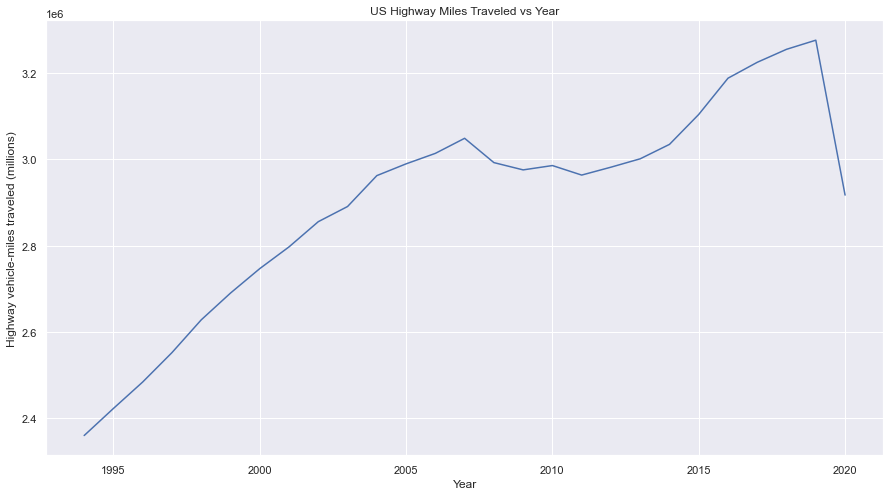

In [4]:
# Reformat data into columns using pivot table
df = pd.pivot_table(state_transport_data, index = ["State", "Year"], columns = "Measures", values="Values").reset_index()

# Visualize how highway miles traveled has changed over time
p = sns.lineplot(data = df[df["State"] == "United States"], x ="Year", y="Highway vehicle-miles traveled (millions)")
p.set(title="US Highway Miles Traveled vs Year");

In [5]:
# Perform data cleaning
# -- Puerto Rico removed because it does not include fatalities data
# -- United states removed because it captures the rest of the data
# -- Years above 2019 removed because of COVID
# -- Years before 1994 removed because highway miles data
#    only goes as far back as 1994 (measurement differed in earlier years)
# -- Drop 'persons' columns with NaN entries in the given time period.
df_cleaned = df[(df["State"] != "Puerto Rico")&(df["State"] != "United States")&(df["Year"]<=2020)&(1994<=df["Year"])]
df_cleaned = df_cleaned.drop(["Person miles (millions)", "Person trips (millions)", "Persons traveling (thousands)"], axis = 1)

# Add treatment variable.
df_cleaned["year_adopted"] = df_cleaned["State"].apply(lambda x: year_adopted[x])
df_cleaned["adopted"] = df_cleaned["Year"] >= df_cleaned["year_adopted"]

# Add 'years since adoption' variable
# -- 0 before adoption, 1 in year of adoption, 2 in year after adoption etc.
year_difference = df_cleaned["Year"] - df_cleaned["year_adopted"] + 1
df_cleaned["years_since_adoption"] = np.maximum(year_difference, 0)

# More data cleaning
# -- Reduce set of states to those that had a transition during the given time period.
#    1994 - 2019 inclusive. (Avoid never-taker and always-taker states).
df_cleaned = df_cleaned[(df_cleaned["year_adopted"] > 1994)&(df_cleaned["year_adopted"]<2020)]
df_cleaned.head()

Measures,State,Year,Highway Fatalities,Highway use of gasoline (thousand gallons),Highway vehicle-miles traveled (millions),Licensed drivers,Transit Ridership,Vehicles,year_adopted,adopted,years_since_adoption
45,Alabama,1994,1083.0,2220444.0,48956.0,2860724.0,9682137.0,3176560.0,1999.0,False,0.0
46,Alabama,1995,1114.0,2283380.0,50628.0,3456100.0,9712920.0,3552840.0,1999.0,False,0.0
47,Alabama,1996,1146.0,2274640.0,51433.0,3138237.0,5811397.0,3406720.0,1999.0,False,0.0
48,Alabama,1997,1192.0,2303025.0,53458.0,3387123.0,30766361.0,3669440.0,1999.0,False,0.0
49,Alabama,1998,1071.0,2383298.0,55205.0,3434117.0,2792639.0,3858930.0,1999.0,False,0.0


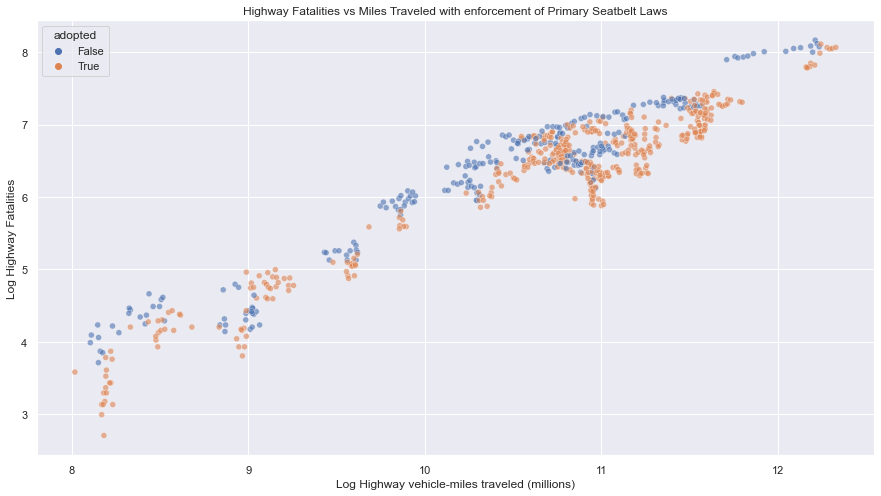

In [6]:
# Add log of highway fatalities and miles traveled
# and ratio of highway fatalities to miles traveled to dataset.
# and log ratio to dataset.
df_ratio = df_cleaned.copy()
df_ratio["Log Highway vehicle-miles traveled (millions)"] = np.log(df_cleaned["Highway vehicle-miles traveled (millions)"])
df_ratio["Log Highway Fatalities"] = np.log(df_cleaned["Highway Fatalities"])
df_ratio["Fatals/miles"] = df_ratio["Highway Fatalities"]/df_ratio["Highway vehicle-miles traveled (millions)"]

# Visualize highway fatalities vs miles traveled
p = sns.scatterplot(data = df_ratio, x = "Log Highway vehicle-miles traveled (millions)", y = "Log Highway Fatalities", hue="adopted", alpha = 0.6)
p.set(title="Highway Fatalities vs Miles Traveled with enforcement of Primary Seatbelt Laws");

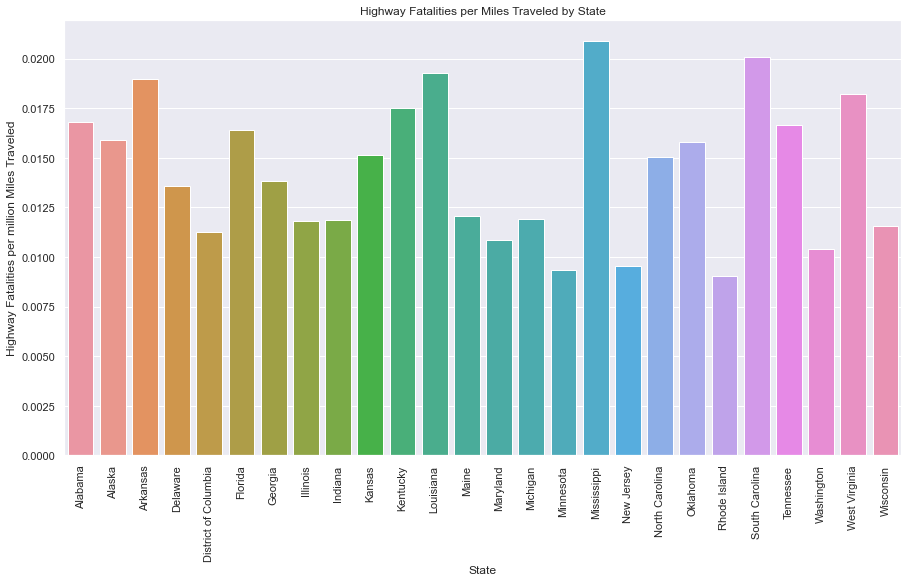

In [7]:
# Visualize mean highway fatalities per miles traveled in different states
df_means = df_ratio.loc[:,["State", "Fatals/miles"]].groupby("State").agg("mean").reset_index()
p = sns.barplot(data = df_means, x = "State", y = "Fatals/miles")
p.set_xticklabels(p.get_xticklabels(),rotation = 90)
p.set(title="Highway Fatalities per Miles Traveled by State", ylabel = "Highway Fatalities per million Miles Traveled");

### MIT Election Data

In [8]:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX
presidents = pd.read_csv("1976-2020-president.csv")

# Filter data for relevant time period 1994-2019 inclusive.
# Need data from 1992 election to fill 1992-1996 range.
presidents = presidents[(presidents["year"] <= 2019)&(1992 <= presidents["year"])]

# Calculate proportion of votes cast for each candidate
presidents["prop"] = presidents["candidatevotes"]/presidents["totalvotes"]

# Reformat data into columns using pivot table.
presidents = presidents.loc[:, ["year", "state", "prop", "party_simplified"]]
presidents = pd.pivot_table(presidents, index = ["state", "year"], columns = "party_simplified", values="prop").reset_index()

# Drop excess columns.
# -- Other can be captured by other columns. Libertarian sometimes NaN.
presidents = presidents.drop(["LIBERTARIAN", "OTHER"], axis = 1)
presidents.head()

party_simplified,state,year,DEMOCRAT,REPUBLICAN
0,ALABAMA,1992,0.408801,0.476454
1,ALABAMA,1996,0.431561,0.501218
2,ALABAMA,2000,0.415665,0.564838
3,ALABAMA,2004,0.368444,0.624607
4,ALABAMA,2008,0.387404,0.603169


### Data Merging and Pre-Processing

In [9]:
# Create df to expand president dataframe to include non-election years
election_years = np.array([[year]*4 for year in presidents["year"].unique()]).flatten()
years = np.array([[year, year + 1, year + 2, year + 3] for year in presidents["year"].unique()]).flatten()
all_years = pd.DataFrame({"year":election_years, "expanded_year":years})

# Election data with non-election years.
presidents_years = presidents.merge(all_years, on = "year")
presidents_years = presidents_years.drop("year", axis =1)

# Convert data and columns to appropriate format for join.
df_ratio["State"] = df_ratio["State"].apply(str.lower)
presidents_years["state"] = presidents_years["state"].apply(str.lower)
presidents_years = presidents_years.rename(columns = {"state":"State", "expanded_year":"Year"})

# Join dataframes.
df_joined = df_ratio.merge(presidents_years, how="inner", on = ["State", "Year"])
df_joined.head()

# 4 years starting with election year are all classified as having the same republican/democrat values. (MENTION)

,State,Year,Highway Fatalities,Highway use of gasoline (thousand gallons),Highway vehicle-miles traveled (millions),Licensed drivers,Transit Ridership,Vehicles,year_adopted,adopted,years_since_adoption,Log Highway vehicle-miles traveled (millions),Log Highway Fatalities,Fatals/miles,DEMOCRAT,REPUBLICAN
0,alabama,1994,1083.0,2220444.0,48956.0,2860724.0,9682137.0,3176560.0,1999.0,False,0.0,10.798677,6.987490,0.022122,0.408801,0.476454
1,alabama,1995,1114.0,2283380.0,50628.0,3456100.0,9712920.0,3552840.0,1999.0,False,0.0,10.832260,7.015712,0.022004,0.408801,0.476454
2,alabama,1996,1146.0,2274640.0,51433.0,3138237.0,5811397.0,3406720.0,1999.0,False,0.0,10.848035,7.044033,0.022281,0.431561,0.501218
3,alabama,1997,1192.0,2303025.0,53458.0,3387123.0,30766361.0,3669440.0,1999.0,False,0.0,10.886652,7.083388,0.022298,0.431561,0.501218
4,alabama,1998,1071.0,2383298.0,55205.0,3434117.0,2792639.0,3858930.0,1999.0,False,0.0,10.918809,6.976348,0.019400,0.431561,0.501218


In [10]:
# One-hot encoding
from sklearn.preprocessing import OneHotEncoder
def ohe_column(data, name):
    """
    One-hot-encodes elements in the column named NAME. New columns are of the form NAME_ENTRY.
    """
    enc = OneHotEncoder(sparse=False, drop = "first")
    enc.fit(data[[name]])
    df = pd.DataFrame(enc.transform(data[[name]]), columns = enc.get_feature_names_out(), index = data.index)
    return data.join(df)

# Use one hot encoding for categorical variables State and Years
# and create variable to track column names for confounders
# Drop one column for each to prevent multicolinearity.
df_ohe = ohe_column(df_joined, "Year")
df_ohe = ohe_column(df_ohe, "State")

# Remove repeated data.
excess_cols = ["Highway vehicle-miles traveled (millions)",
               "Log Highway Fatalities","Log Highway vehicle-miles traveled (millions)",
               "Highway Fatalities", "State", "Year", "year_adopted"]
df_ohe = df_ohe.drop(excess_cols, axis = 1)
df_ohe.head()

,Highway use of gasoline (thousand gallons),Licensed drivers,Transit Ridership,Vehicles,adopted,years_since_adoption,Fatals/miles,DEMOCRAT,REPUBLICAN,Year_1995,...,State_mississippi,State_new jersey,State_north carolina,State_oklahoma,State_rhode island,State_south carolina,State_tennessee,State_washington,State_west virginia,State_wisconsin
0,2220444.0,2860724.0,9682137.0,3176560.0,False,0.0,0.022122,0.408801,0.476454,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2283380.0,3456100.0,9712920.0,3552840.0,False,0.0,0.022004,0.408801,0.476454,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2274640.0,3138237.0,5811397.0,3406720.0,False,0.0,0.022281,0.431561,0.501218,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2303025.0,3387123.0,30766361.0,3669440.0,False,0.0,0.022298,0.431561,0.501218,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2383298.0,3434117.0,2792639.0,3858930.0,False,0.0,0.019400,0.431561,0.501218,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Deal with null entries (This method simply removes rows with any null entries.)
# There is only one row with mission transit ridership data removed. (MENTION)
print(len(df_ohe))
df_ohe = df_ohe.drop(df_ohe[df_ohe.isnull().values == True].index).reset_index()
assert not df_ohe.isnull().values.any()
print(len(df_ohe))

676
675


### Outcome Regression

In [13]:
import statsmodels.api as sm

confounders = df_ohe.columns.drop(["index", "Fatals/miles", "adopted"])
treatment = "adopted"
outcome = "Fatals/miles"

# Function copied from lab 8
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables].astype(float)
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

# OLS with intercept to account for columns excluded from OHE
explanatory_variables = np.append(confounders, treatment)
ols_model = fit_OLS_model(df_ohe, outcome, explanatory_variables, intercept = True)
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           Fatals/miles   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     126.4
Date:                Sat, 07 May 2022   Prob (F-statistic):          4.84e-303
Time:                        09:36:50   Log-Likelihood:                 3560.2
No. Observations:                 675   AIC:                            -7002.
Df Residuals:                     616   BIC:                            -6736.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Propensity Score Calculation

In [14]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression as LR
lr = LR(penalty='none', max_iter=200, random_state=908)

# Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier as GBC
gbc = GBC(learning_rate = 0.01, random_state=71, min_samples_split = 20, min_samples_leaf = 20)
# Note that not matter what model we try the outcome has perfect accuracy.
# This is likely because it can split on years since adoption. (MENTION)

# generate propensity scores using specified model
def propensity_scores(data, model, treatment, confounders, outcome):
    X = df_ohe.loc[:, confounders]
    Z = df_ohe.loc[:, treatment]
    Y = df_ohe.loc[:, outcome]
    model.fit(X, Z)
    e = model.predict_proba(X)[:, 1]
    return e

prop_scores = propensity_scores(df_ohe, lr, treatment, confounders, outcome)
gbc_prop_scores = propensity_scores(df_ohe, gbc, treatment, confounders, outcome)

LR log-loss: 0.6243941901826866
GBC log-loss: 0.18985267924259935
LR accuracy: 0.6607407407407407
GBC accuracy: 1.0


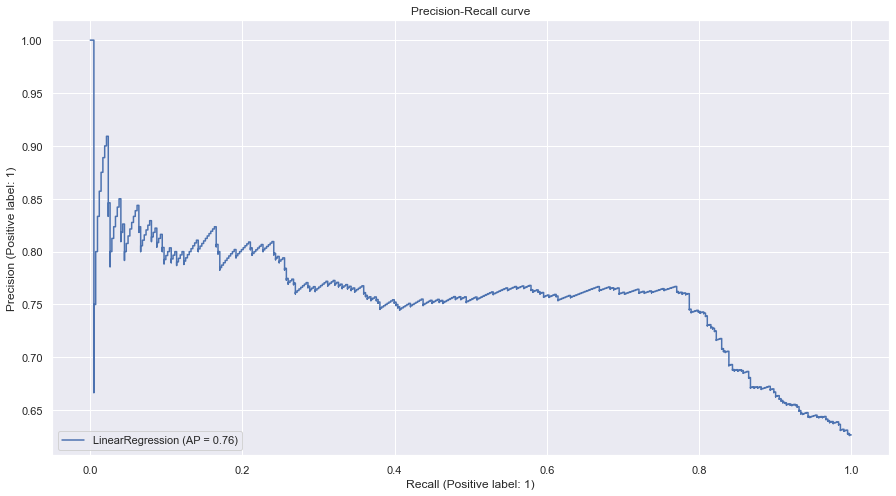

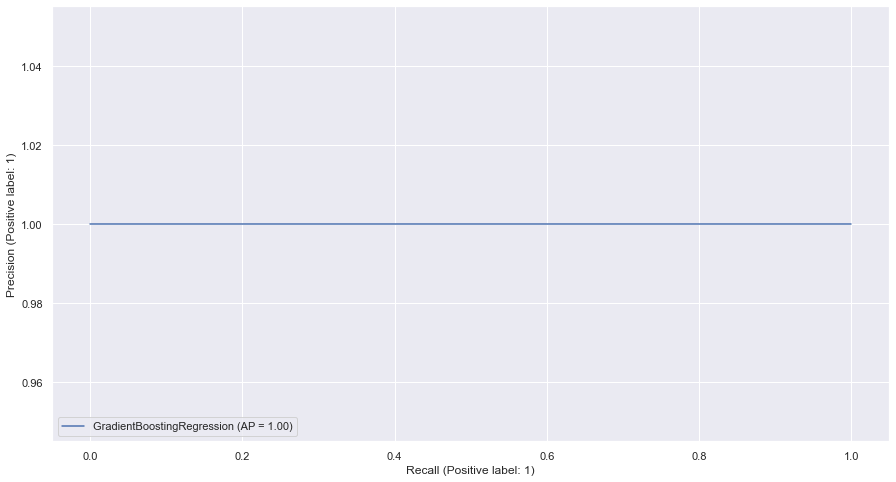

In [15]:
# Determine which propensty scores should be used
y_test = df_ohe[treatment]
from sklearn.metrics import log_loss, accuracy_score, PrecisionRecallDisplay

# log-loss
print("LR log-loss:", log_loss(y_test, prop_scores))
print("GBC log-loss:", log_loss(y_test, gbc_prop_scores))

# accuracy
y_pred_lr = lr.predict(df_ohe[confounders])
y_pred_gbc = gbc.predict(df_ohe[confounders])
print("LR accuracy:", accuracy_score(y_test, y_pred_lr))
print("GBC accuracy:", accuracy_score(y_test, y_pred_gbc))

# precision-recall
display = PrecisionRecallDisplay.from_predictions(y_test, prop_scores, name="LinearRegression")
display.ax_.set_title("Precision-Recall curve")
display = PrecisionRecallDisplay.from_predictions(y_test, gbc_prop_scores, name="GradientBoostingRegression")

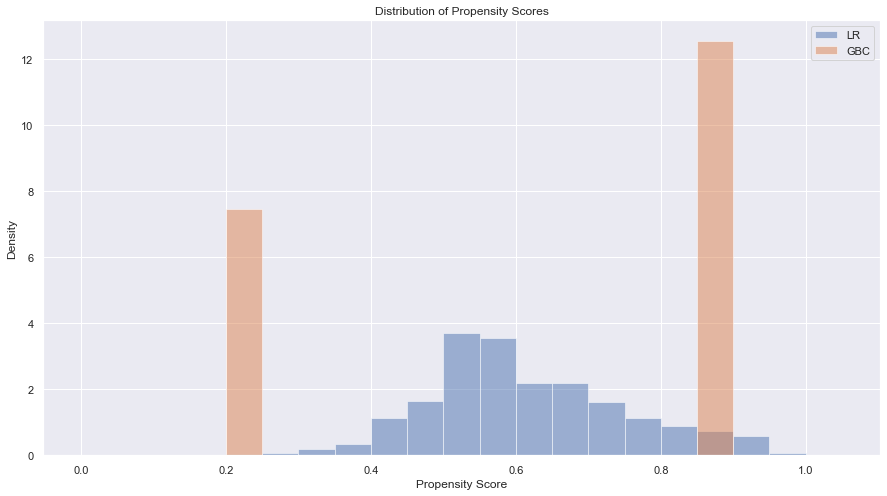

In [16]:
# Visualize propensity score distributions
bins = np.arange(0, 1.1, 0.05)
plt.hist(prop_scores, density=True, label="LR", alpha=0.5, bins=bins)
plt.hist(gbc_prop_scores, density=True, label="GBC", alpha=0.5, bins=bins)
plt.legend()
plt.title("Distribution of Propensity Scores")
plt.ylabel("Density")
plt.xlabel("Propensity Score");

### Inverse Propensity Weighting

In [17]:
def ipw_estimate(data, treatment, outcome, e, left=0, right=1):
    temp = data.copy()
    temp["e"] = e
    temp = temp[(temp["e"] > left) & (temp["e"] < right)]
    e = temp["e"]
    Z = temp[outcome]
    Y = temp[treatment]
    return np.mean((Z*Y)/e - ((1-Z)*Y)/(1-e))

gbc_estimate = ipw_estimate(df_ohe, treatment, outcome, gbc_prop_scores, left=0.1, right=0.9)
lr_estimate = ipw_estimate(df_ohe, treatment, outcome, prop_scores, left=0.1, right=0.9)
print("Interpret as: The treatment has <estimate> effect on highwat fatalities per million miles traveled.")
print("GBC Estimate:", gbc_estimate)
print("LR Estimate:", lr_estimate)

Interpret as: The treatment has <estimate> effect on highwat fatalities per million miles traveled.
GBC Estimate: -4.502044231171002
LR Estimate: -1.9247907888632652


95% confidence interval: (-1.920044010698084, -1.6848656236418567)


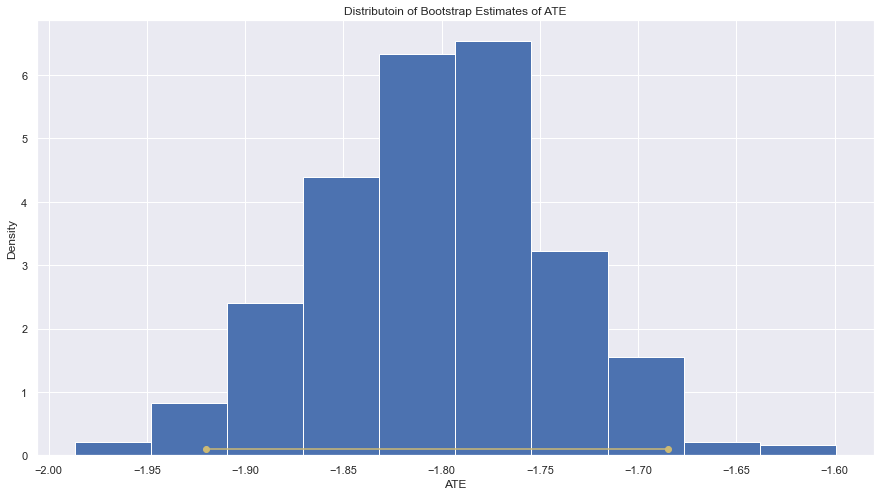

In [18]:
# Bootstrap to find confidence interval for IPW estimate
n = 1000
estimates = np.zeros(shape=(n,))
np.random.seed(1234)

for i in np.arange(n):
    sample_data = df_ohe.sample(frac = 1, replace = True)
    e = propensity_scores(sample_data, lr, treatment, confounders, outcome)
    tau = ipw_estimate(sample_data, treatment, outcome, e, left = 0.1, right = 0.9)
    estimates[i] = tau

# find 95% confidence interval around data
bootstrap_std = np.std(estimates)
mu_taus = np.mean(estimates)
ci_95 = (mu_taus-1.96*bootstrap_std, mu_taus+1.96*bootstrap_std)
print("95% confidence interval:", ci_95)

# Visualize distribution of estimates
plt.hist(estimates, density=True)
plt.ylabel("Density")
plt.xlabel("ATE")
plt.title("Distributoin of Bootstrap Estimates of ATE")
plt.plot(ci_95,(0.1,0.1),'yo-');